<a href="https://colab.research.google.com/github/SAILResearch/AI_Teammates_in_SE3/blob/main/analysis/language_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

try:
  from helper import FIG_DIR, PREFER_ORDER, COLOR_MAP
except Exception:
  FIG_DIR = Path("figs")
  FIG_DIR.mkdir(exist_ok=True)
  COLOR_MAP = {
    "Human": "#56B4E9",
    "OpenAI_Codex": "#D55E00",
    "OpenAI Codex": "#D55E00",
    "Codex": "#F0E442",
    "Devin": "#009E73",
    "Copilot": "#0072B2",
    "GitHub Copilot": "#0072B2",
    "Cursor": "#785EF0",
    "Claude_Code": "#DC267F",
    "Claude Code": "#DC267F",
  }
  PREFER_ORDER = [
    "Human",
    "OpenAI_Codex",
    "Devin",
    "Copilot",
    "Cursor",
    "Claude_Code"
  ]

# Load Hugging Face datasets
repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/repository.parquet")
pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")

# –– Nature-ready styling
mpl.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times'],
    'mathtext.fontset': 'stix',
    'axes.linewidth': 1.0,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'legend.title_fontsize': 14,
    'figure.dpi': 300,
})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:



# %%
def list_agents(scope: bool = False) -> list[str]:
    """Return unique agent names from pr_df."""
    agents = sorted(pr_df["agent"].dropna().unique())
    return agents


def load_repo_meta(agent: str, scope: bool = False) -> pd.DataFrame:
    """
    Load repository metadata for one agent from in-memory DataFrames.
    Only returns repos that have PRs by this agent.
    """
    agent_prs = pr_df[pr_df["agent"] == agent]
    if agent_prs.empty:
        raise FileNotFoundError(f"No PRs found for agent {agent}")

    repo_subset = repo_df[repo_df["url"].isin(agent_prs["repo_url"])]
    return repo_subset


def language_counts(agent: str, scope: bool = False) -> pd.DataFrame:
    """Return repo-counts per language for a single agent."""
    df = load_repo_meta(agent, scope)
    counts = df["language"].value_counts(dropna=False).reset_index()
    counts.columns = ["language", "count"]
    return counts


def plot_language_usage(counts: pd.DataFrame, agent: str, scope: bool = False) -> None:
    """Bar-plot language frequencies for one agent."""
    if counts.empty:
        print(f"No language data for {agent}")
        return
    plt.figure(figsize=(6, 4))
    sns.barplot(x="language", y="count", data=counts, color="tab:blue")
    plt.xlabel("Language")
    plt.ylabel("Repository Count")
    title = f"{agent} repo languages" + (" (scope)" if scope else "")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    FIG_DIR.mkdir(exist_ok=True, parents=True)
    suffix = "_scope" if scope else ""
    out = FIG_DIR / f"{agent}_languages{suffix}.png"
    plt.savefig(out)
    plt.close()
    print("Wrote", out)


def process_agent(agent: str, scope: bool = False) -> None:
    """Create per-agent CSV and bar-plot."""
    try:
        counts = language_counts(agent, scope)
    except FileNotFoundError as e:
        print(e)
        return

    out_fp = FIG_DIR / f"{agent}_languages.csv"
    counts.to_csv(out_fp, index=False)
    print("Wrote", out_fp)
    plot_language_usage(counts, agent, scope)


# %%
TOP_N = 10


def _collect_stats(agents: list[str], scope: bool):
    count_frames = []
    all_repos = []

    for agent in agents:
        df = load_repo_meta(agent, scope)[["url", "language"]]
        df = df.drop_duplicates(subset="url")
        df["agent"] = agent
        all_repos.append(df)
        print(f"Processing {agent} with {len(df)} repositories, {df['language'].isna().sum()} missing languages")

        counts = df["language"].value_counts(dropna=False)
        count_frames.append(counts.rename(agent))

    count_df = pd.concat(count_frames, axis=1).T.fillna(0).astype(int)
    pct_df = (count_df.T / count_df.sum(axis=1)).T * 100
    pct_df = pct_df.round(1)

    combined_df = pd.concat(all_repos).drop_duplicates(subset="url")
    dedup_totals = combined_df["language"].value_counts(dropna=False).sort_values(ascending=False).astype(int)

    return count_df, pct_df, dedup_totals


def _build_summary_table(count_df: pd.DataFrame, pct_df: pd.DataFrame, totals: pd.Series) -> pd.DataFrame:
    agents = [a for a in PREFER_ORDER if a != "Human" and a in count_df.index]
    top_langs = totals.index
    count_slice = count_df.loc[agents, top_langs].T
    pct_slice = pct_df.loc[agents, top_langs].T

    total_repos = totals.sum()
    overall_pct = (totals / total_repos * 100).round(1)
    overall_count = totals.loc[top_langs]

    total_data = pd.concat([overall_count, overall_pct], axis=1)
    total_data.columns = [("Total", "#"), ("Total", "%")]

    cols, data_parts = [], []
    for agent in agents:
        cols.extend([(agent, "#"), (agent, "%")])
        data_parts.append(count_slice[agent])
        data_parts.append(pct_slice[agent])

    agent_data = pd.concat(data_parts, axis=1)
    agent_data.columns = pd.MultiIndex.from_tuples(cols)

    table = pd.concat([total_data, agent_data], axis=1)
    table.index.name = "Language"
    table = table.loc[top_langs]

    int_cols = [col for col in table.columns if col[1] == "#"]
    table[int_cols] = table[int_cols].astype(int)
    return table


def _latex(table: pd.DataFrame) -> str:
    n_agents = len(table.columns) // 2
    col_fmt = "l" + "r" * (2 * n_agents)
    return table.to_latex(
        float_format="{:.1f}".format,
        column_format=col_fmt,
        multicolumn=True,
        multicolumn_format="c",
        caption=f"Top-{TOP_N} languages across agents: per-agent rank and percentage.",
        label="tab:language-usage",
        na_rep=""
    )


def run_summary(scope: bool = False):
    agents = [a for a in list_agents(scope) if a != "Human"]
    if not agents:
        print("No non-human agents found")
        return
    count_df, pct_df, totals = _collect_stats(agents, scope)
    table = _build_summary_table(count_df, pct_df, totals)
    print(_latex(table))
    return count_df, pct_df, totals

In [3]:

count_df, pct_df, totals = run_summary(scope=True)

Processing Claude_Code with 213 repositories, 2 missing languages
Processing Copilot with 1012 repositories, 18 missing languages
Processing Cursor with 327 repositories, 2 missing languages
Processing Devin with 288 repositories, 1 missing languages
Processing OpenAI_Codex with 1248 repositories, 14 missing languages
\begin{table}
\caption{Top-10 languages across agents: per-agent rank and percentage.}
\label{tab:language-usage}
\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & ('Total', '#') & ('Total', '%') & ('OpenAI_Codex', '#') & ('OpenAI_Codex', '%') & ('Devin', '#') & ('Devin', '%') & ('Copilot', '#') & ('Copilot', '%') & ('Cursor', '#') & ('Cursor', '%') & ('Claude_Code', '#') & ('Claude_Code', '%') \\
language &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
TypeScript & 650 & 23.2 & 247 & 19.8 & 137 & 47.6 & 196 & 19.4 & 136 & 41.6 & 57 & 26.8 \\
Python & 530 & 18.9 & 304 & 24.4 & 51 & 17.7 & 132 & 13.0 & 57 & 17.4 & 53 & 24.9 \\
Go & 242 & 8.6 & 110 & 8.8 & 20 & 6.9 & 88 & 8.7 & 22

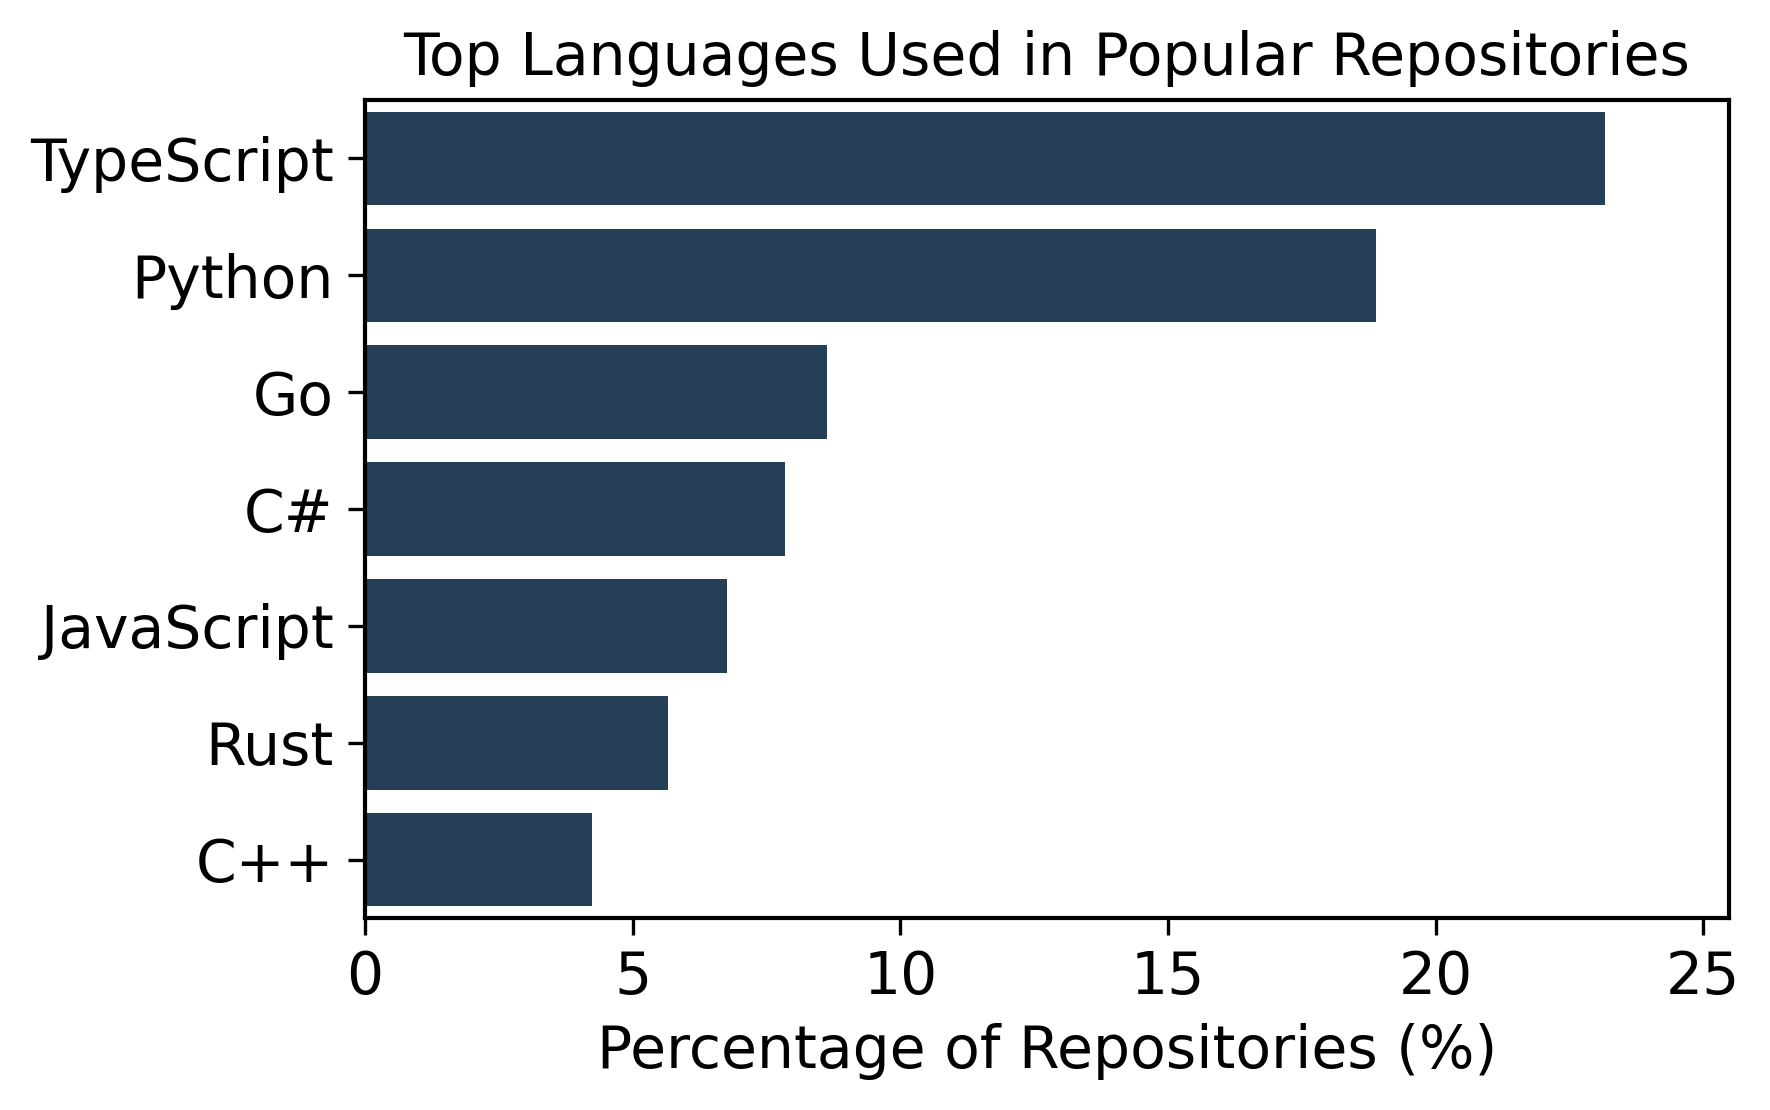

Wrote figs/total_language_percentages_top.png


In [4]:


# %%
def plot_total_language_percentages(totals: pd.Series, top_n: int = TOP_N, scope: bool = False) -> None:
    if totals.empty:
        print("No language totals to plot.")
        return
    pct = (totals / totals.sum() * 100).sort_values(ascending=False)
    if top_n:
        pct = pct.head(top_n)

    plt.figure(figsize=(6, 0.4 * len(pct) + 1))
    sns.barplot(y=pct.index, x=pct.values, orient="h", color="#1C3F60")
    plt.grid(False)
    plt.xlabel("Percentage of Repositories (%)")
    plt.ylabel(None)
    plt.title("Top Languages Used in Popular Repositories")
    plt.xlim(0, pct.max() * 1.10)
    plt.tight_layout()

    FIG_DIR.mkdir(parents=True, exist_ok=True)
    out = FIG_DIR / f"total_language_percentages_top.png"
    plt.savefig(out)
    plt.show()
    plt.close()
    print("Wrote", out)


# %%
plot_total_language_percentages(totals, top_n=7)
